In [1]:
%load_ext pycodestyle_magic
%flake8_on
# la convention PEP8 est ainsi testée

In [22]:
# importer les packages
# common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ml
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FactorAnalysis
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
# plot
from mpl_toolkits.mplot3d import Axes3D
sns.set_style('whitegrid')
%matplotlib inline

1: E999 SyntaxError: invalid syntax


In [3]:
# récupérer les données
data = pd.read_csv('Data/data.csv')

In [38]:
data.sample(5)

,payment_installments_size,payment_total,main_payment_type_boleto,main_payment_type_credit_card,main_payment_type_debit_card,main_payment_type_voucher,freight_percentage,charm_price,total_freight,purchase_time_zone_AM-WD,...,product_desc_length_lvl,product_name_length_lvl,product_photos_qty_lvl,product_size_lvl,product_weight_g_lvl,product_density_lvl,freight_percentage_lvl,cust_sell_dist_lvl,order_purchase_year,order_purchase_month
55563,4.0,185.94,0,1,0,0,8.578036,1,15.95,0,...,BelowMed_DescLength,OverMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,Light_Weight,Light_Density,BelowMed_FreightCost,AroundMed_Dist,2017,11
35638,10.0,555.32,0,1,0,0,4.577541,1,25.42,0,...,AroundMed_DescLength,BelowMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,BelowMed_FreightCost,Far_Dist,2018,3
69325,1.0,1442.15,1,0,0,0,2.929654,1,42.25,0,...,TooHigh_DescLength,AroundMed_NameLength,OverMed_PhotoQty,Big_Size,Heavy_Weight,ArounMed_Density,BelowMed_FreightCost,Far_Dist,2017,9
8725,1.0,52.32,0,1,0,0,37.117737,1,19.42,1,...,BelowMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,OverMed_FreightCost,AroundMed_Dist,2018,7
6515,4.0,92.45,0,1,0,0,19.091401,0,17.65,0,...,AroundMed_DescLength,AroundMed_NameLength,AroundMed_PhotoQty,AroundMed_Size,ArounMed_Weight,ArounMed_Density,AroundMed_FreightCost,Near_Dist,2018,7


In [4]:
# rappel des features
# pour découper des jeux de données temporelles
temporal_cut_features = ['order_purchase_year', 'order_purchase_month']
# pour décrire les clusters
for_lvl_features = ['delivery_vs_estimated_lvl',
                    'product_desc_length_lvl',
                    'product_name_length_lvl',
                    'product_photos_qty_lvl',
                    'product_size_lvl',
                    'product_weight_g_lvl',
                    'product_density_lvl',
                    'freight_percentage_lvl',
                    'cust_sell_dist_lvl']
# pour décrire les catégories de produit
cat_feat_product = data.columns[data.columns.str.contains(
    'rational_category_')].tolist()
# pour réaliser le clustering
feature_selection = ['payment_installments_size',
                     'payment_total',
                     'main_payment_type_boleto',
                     'main_payment_type_credit_card',
                     'main_payment_type_debit_card',
                     'main_payment_type_voucher',
                     'freight_percentage',
                     'charm_price',
                     'total_freight',
                     'purchase_time_zone_AM-WD',
                     'purchase_time_zone_Evening-Sun',
                     'purchase_time_zone_Evening-WD',
                     'purchase_time_zone_Night',
                     'purchase_time_zone_PM-WD',
                     'purchase_time_zone_WE',
                     'product_review_mean',
                     'customer_review_mean']

In [5]:
# projection sur les données
data_selection = data.filter(feature_selection)
data_selection.shape

(90360, 17)

In [6]:
# fonction de transformation des features numériques


def rankgauss(data, feature):
    # crée une instance de quatiletransformer
    transformer = QuantileTransformer(n_quantiles=100,
                                      random_state=1111,
                                      output_distribution='normal')
    # adpate au feature
    transformer.fit(data[[feature]])
    # préfixe le nouveau feature
    newfeat = str('N_RG_' + feature)
    # ajoute le nouveau feature transformé
    data[newfeat] = transformer.transform(data[[feature]])
    # nb on ne retire pas le feature dans sa version d'origine
    # retourne le nouveau dataframe
    return data


In [7]:
raw_features = ['payment_installments_size',
                'payment_total',
                'freight_percentage',
                'total_freight',
                'product_review_mean',
                'customer_review_mean']

In [8]:
# appliquer le rankgauss aux features bruts
for i in raw_features:
    print(i)
    data_selection = rankgauss(data_selection, i)
    print(data_selection.shape)

payment_installments_size
(90360, 18)
payment_total
(90360, 19)
freight_percentage
(90360, 20)
total_freight
(90360, 21)
product_review_mean
(90360, 22)
customer_review_mean
(90360, 23)


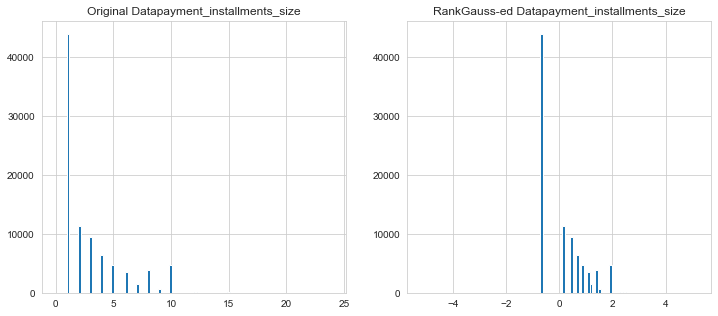

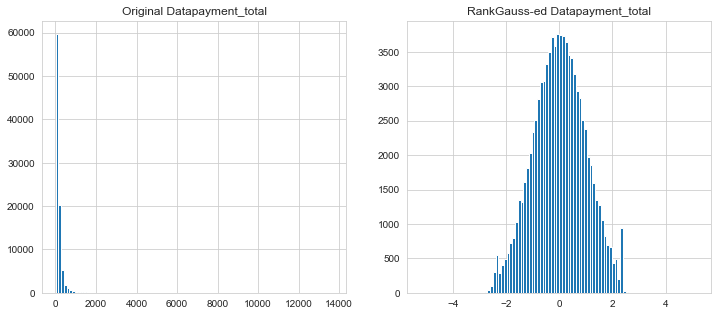

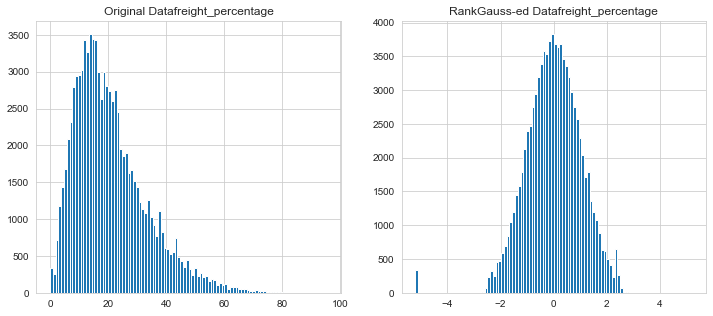

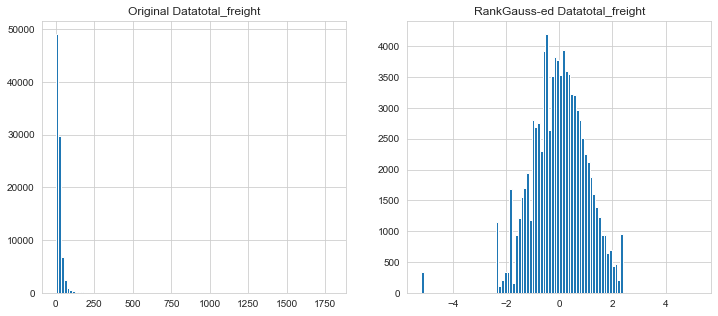

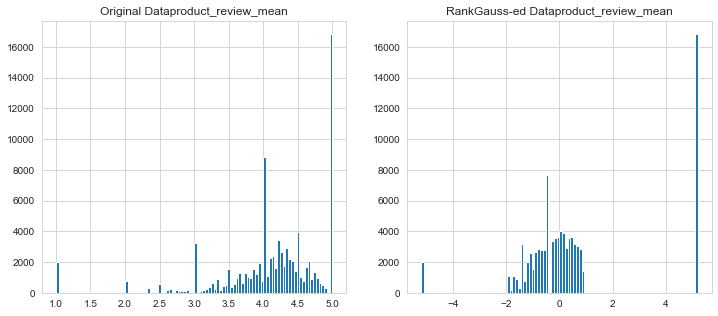

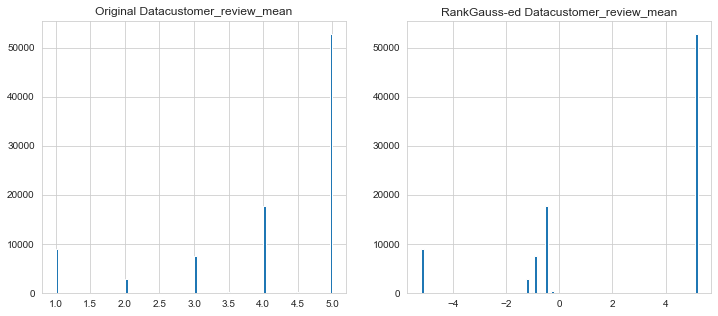

In [9]:
# observer le résultat du traitement rankgauss:
for i in raw_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    ax1.hist(data_selection[i], bins=100)
    ax1.title.set_text(str('Original Data' + i))
    ax2.hist(data_selection[str('N_RG_' + i)], bins=100)
    ax2.title.set_text(str('RankGauss-ed Data' + i))
    plt.show()

In [10]:
# retirer les features dans leur version d'origine
for i in raw_features:
    print(i)
    data_selection.drop(i, axis=1, inplace=True)
    print(data_selection.shape)

payment_installments_size
(90360, 22)
payment_total
(90360, 21)
freight_percentage
(90360, 20)
total_freight
(90360, 19)
product_review_mean
(90360, 18)
customer_review_mean
(90360, 17)


In [11]:
# standardiser les données
data_std = StandardScaler().fit_transform(data_selection)

# Clustering hierarchique

In [12]:
n = int(data_selection.shape[0]/10)
data_sample = pd.DataFrame(data_std).sample(n, random_state=1)
data_sample.shape

(9036, 17)

In [13]:
data_sample_ = pd.DataFrame(data_std).sample(int(data_selection.shape[0]/5), random_state=42)
data_sample_.shape

(18072, 17)

1:80: E501 line too long (93 > 79 characters)


##  Distance euclidienne 

In [14]:
cl = linkage(data_sample, method='complete', metric='euclidean')

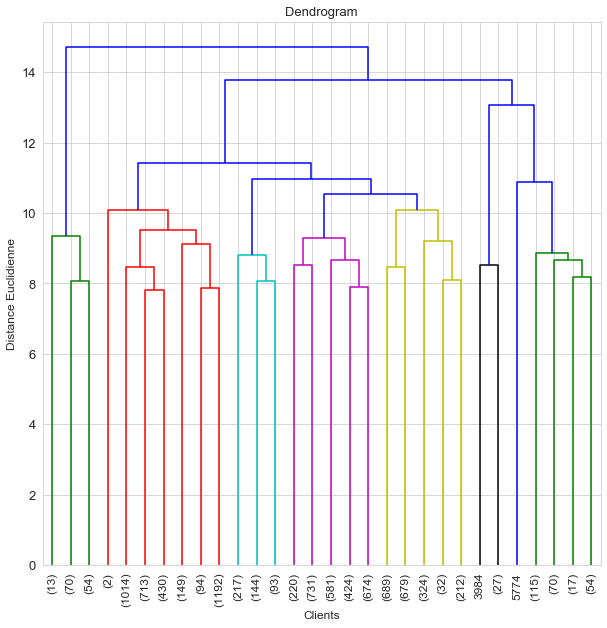

14:34: W291 trailing whitespace


In [15]:
fig = plt.figure(figsize=(10, 10))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Clients', fontsize=12)
ax.set_ylabel('Distance Euclidienne', fontsize=12)
ax.set_title('Dendrogram', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)


dendrogram(cl,
           leaf_rotation=90,
           leaf_font_size=12,
           truncate_mode='lastp', 
           show_leaf_counts=True
           )

plt.show()

##  Distance euclidienne 

In [17]:
cl = linkage(data_sample_, method='complete', metric='euclidean')

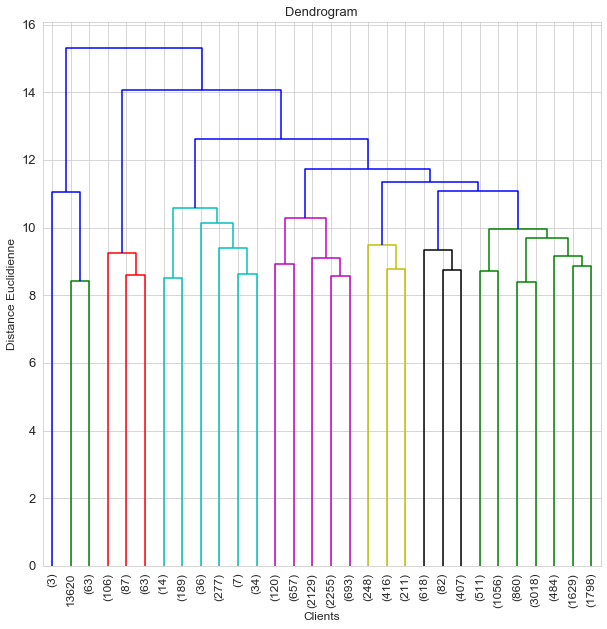

14:34: W291 trailing whitespace


In [18]:
fig = plt.figure(figsize=(10, 10))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Clients', fontsize=12)
ax.set_ylabel('Distance Euclidienne', fontsize=12)
ax.set_title('Dendrogram', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)


dendrogram(cl,
           leaf_rotation=90,
           leaf_font_size=12,
           truncate_mode='lastp', 
           show_leaf_counts=True
           )

plt.show()

## Distance de Mahalanobis

In [91]:
cl = linkage(data_sample, method='complete', metric='mahalanobis')

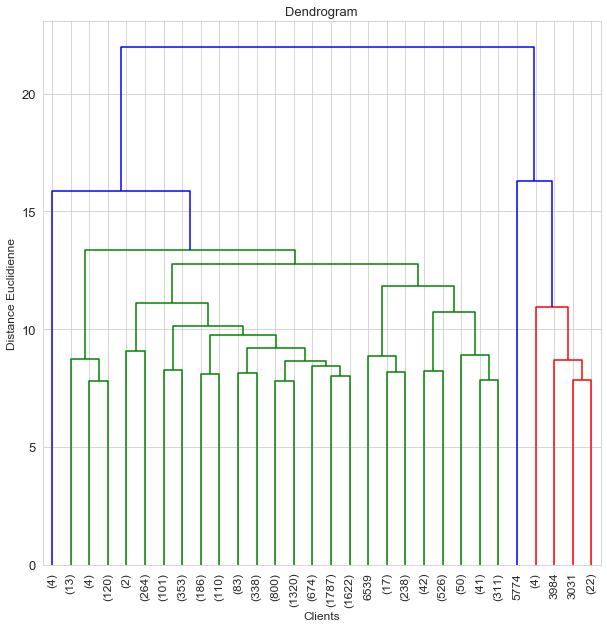

In [92]:
fig = plt.figure(figsize=(10, 10))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Clients', fontsize=12)
ax.set_ylabel('Distance Euclidienne', fontsize=12)
ax.set_title('Dendrogram', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)


dendrogram(cl,
           leaf_rotation=90,
           leaf_font_size=12,
           truncate_mode='lastp', 
           show_leaf_counts=True
           )

plt.show()

## Distance Cityblock

In [93]:
cl = linkage(data_sample, method='complete', metric='cityblock')

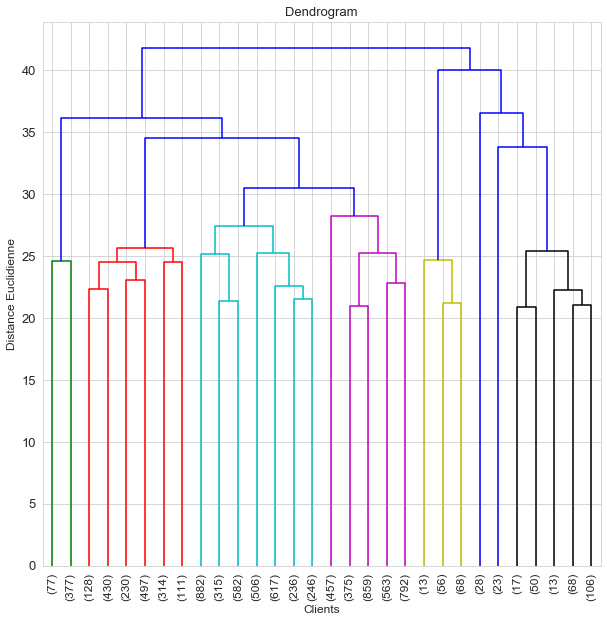

In [94]:
fig = plt.figure(figsize=(10, 10))

# set params of the graphic
ax = fig.add_subplot(111)
ax.set_xlabel('Clients', fontsize=12)
ax.set_ylabel('Distance Euclidienne', fontsize=12)
ax.set_title('Dendrogram', fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)


dendrogram(cl,
           leaf_rotation=90,
           leaf_font_size=12,
           truncate_mode='lastp', 
           show_leaf_counts=True
           )

plt.show()

In [82]:
fl = fcluster(cl,8,criterion='maxclust')

In [83]:
data_sample['clusters'] = fl

In [84]:
data_sample.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,clusters
53606,-0.498478,0.569853,-0.124947,-0.178065,0.638442,-0.52172,-0.233634,-0.582649,3.817231,-0.583024,-0.441195,0.730672,0.875929,0.316568,1.416823,-0.777593,-0.886975,5
18722,-0.498478,0.569853,-0.124947,-0.178065,0.638442,-0.52172,-0.233634,-0.582649,-0.261970,1.715195,-0.441195,0.430261,-0.027802,-0.532068,-0.770646,-0.194604,0.792534,2
31778,-0.498478,0.569853,-0.124947,-0.178065,0.638442,-0.52172,-0.233634,1.716298,-0.261970,-0.583024,-0.441195,-0.892410,-0.093048,-1.176703,-2.017416,1.915202,0.792534,2
15076,-0.498478,0.569853,-0.124947,-0.178065,0.638442,-0.52172,-0.233634,-0.582649,-0.261970,1.715195,-0.441195,0.730672,0.528080,-0.650088,0.240195,-0.122929,-0.886975,2
73204,-0.498478,0.569853,-0.124947,-0.178065,0.638442,-0.52172,-0.233634,-0.582649,-0.261970,-0.583024,2.266569,0.081418,-0.888580,0.614223,-0.593834,-0.661820,-0.766158,2


# PCA
On déroule une PCA sur les features numériques

In [71]:
# contrôler la taille
data_selection.shape

(90360, 17)

In [72]:
# aperçu sur 2 dimensions
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_std)
principalDf = pd.DataFrame(
    data=principalComponents, columns=['F1',
                                       'F2'])

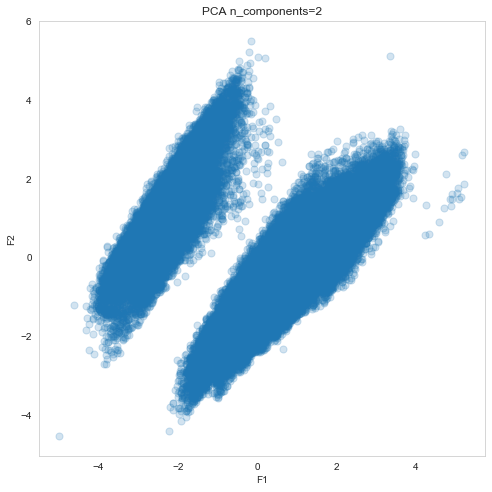

In [73]:
# afficher les données selon les 2 dimensions
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('F1', fontsize=10)
ax.set_ylabel('F2', fontsize=10)
ax.set_title('PCA n_components=2', fontsize=12)

ax.scatter(principalDf['F1'],
           principalDf['F2'], s=50, alpha=0.2)
ax.grid()

In [74]:
# variance
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.15043334 0.10087241]
0.2513057572910161


(-0.7, 0.7)

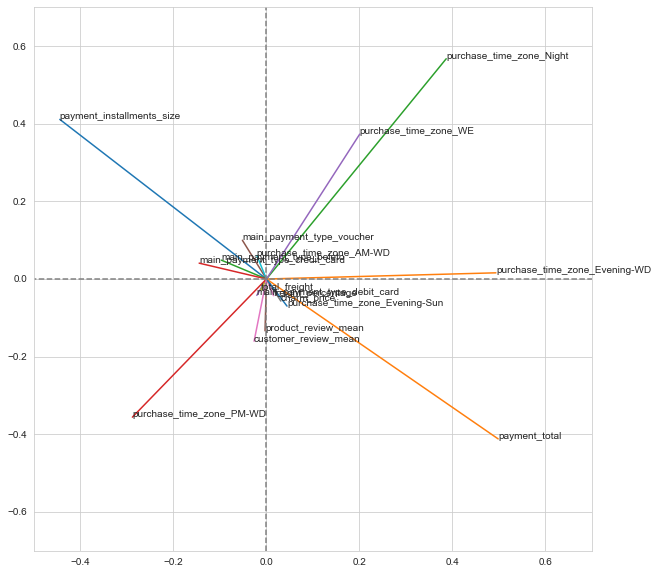

In [75]:
# contribution des variables aux 2 composantes
pcs = pca.components_

fig = plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.plot([0, x], [0, y])
    plt.text(x, y, data.columns[i])
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')
plt.xlim([-0.5, 0.7])
plt.ylim([-0.7, 0.7])

In [76]:
# avec 3 composants
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data_std)
principalDf = pd.DataFrame(
    data=principalComponents, columns=['F1',
                                       'F2',
                                       'F3'])

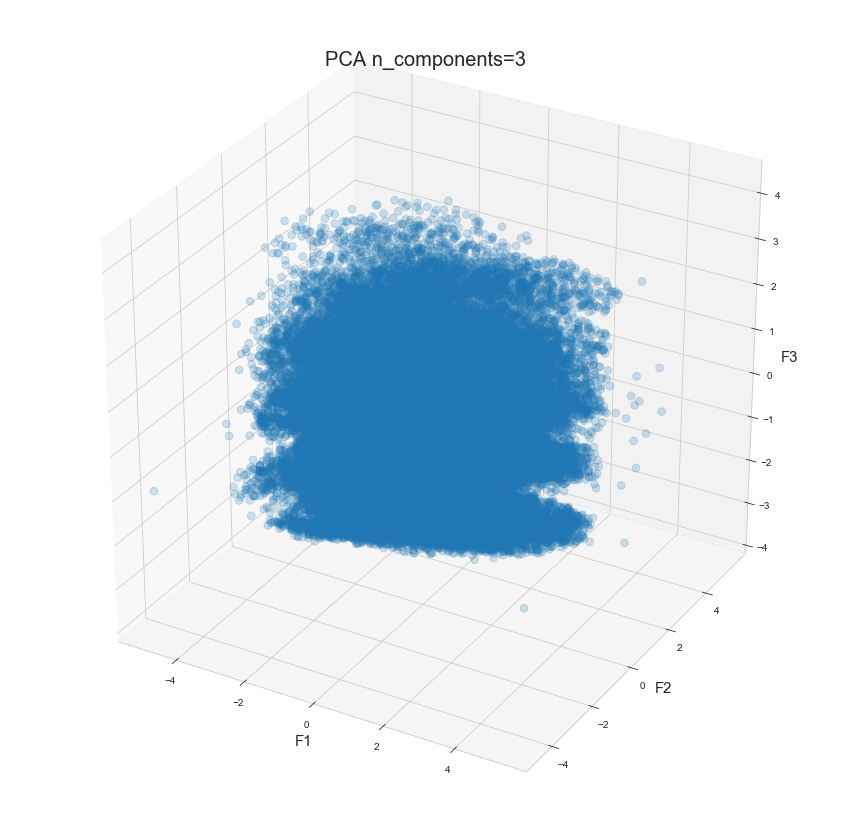

In [77]:
# afficher les données selon les 3 dimensions
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('F1', fontsize=15)
ax.set_ylabel('F2', fontsize=15)
ax.set_zlabel('F3', fontsize=15)
ax.set_title('PCA n_components=3', fontsize=20)

ax.scatter(principalDf['F1'],
           principalDf['F2'],
           principalDf['F3'],
           s=60,
           alpha=0.2)
ax.grid()

In [78]:
# variance
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.15043348 0.10087356 0.0899065 ]
0.34121354407798204


In [79]:
# nombre optimal de components
pca = PCA()
pca.fit(data_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [80]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)


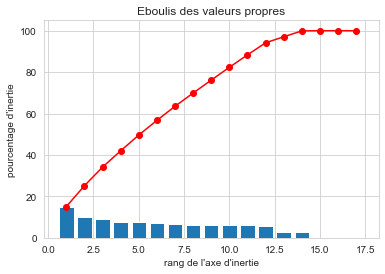

In [81]:
display_scree_plot(pca)

In [21]:
names = []
for i in range(1, 13):
    elt = 'PC' + str(i)
    names.append(elt)

In [22]:
pca_final = PCA(n_components=12)
principalComponents_final = pca_final.fit_transform(data_std)
data_ACP_12CP = pd.DataFrame(
    data=principalComponents_final, columns=names, index=data_selection.index)

In [23]:
data_ACP_12CP.head

<bound method NDFrame.head of             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      0.172687 -1.050185  0.235265 -1.680394  0.856243 -0.629077 -0.243446   
1     -0.045107  0.327748 -1.813170 -1.883674  0.748675 -0.726248 -0.376077   
2     -2.299917 -0.189482  0.155411 -1.179505  1.483659 -0.072277  0.438553   
3      2.390295  1.040191  2.616847 -1.387504  1.057977 -0.024745 -0.272783   
4      1.249736  1.511225 -1.778412 -0.003171 -1.994822 -1.472040 -0.292284   
...         ...       ...       ...       ...       ...       ...       ...   
90355  0.564096 -0.915058  0.086282  1.542922  1.070652 -0.312102 -0.324308   
90356  0.431623 -1.733383 -0.197270  1.466506  1.029217 -0.358242 -0.353998   
90357  1.598075  2.750924 -3.257993  1.264184  0.841073 -0.783438 -0.236872   
90358 -2.515277  0.811842 -0.180226  1.612404  1.177757 -0.021873 -0.435919   
90359 -2.970439  0.604820 -0.092605 -1.606579  0.967250 -0.146668 -0.475773   

            PC8      

In [24]:
sum(pca_final.explained_variance_ratio_)

0.9228076704222394

# K - Means

In [25]:
sse = {}
silhouette = {}
for k in range(2, 13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(data_std)
    silhouette[k] = silhouette_score(data_std, kmeans.labels_)
    sse[k] = kmeans.inertia_

3:23: W291 trailing whitespace
4:11: E225 missing whitespace around operator


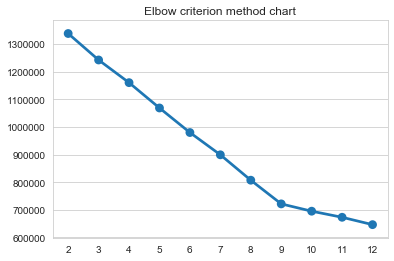

In [26]:
plt.title('Elbow criterion method chart')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

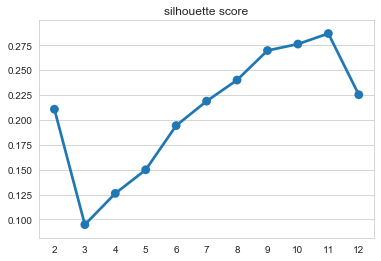

In [27]:
plt.title('silhouette score')
sns.pointplot(x=list(silhouette.keys()), y=list(silhouette.values()))

In [22]:
# contrôler la taille
data.shape

(90360, 8)

In [23]:
data_std.shape

(90360, 101)

# DBSCAN

Estimated number of clusters: 415
Estimated number of noise points: 65766


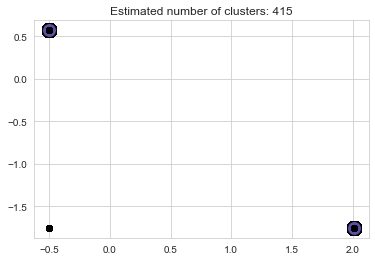

16:80: E501 line too long (80 > 79 characters)
18:80: E501 line too long (88 > 79 characters)
19:80: E501 line too long (103 > 79 characters)


In [31]:
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(data_std)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(data_std, labels))
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data_std[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = data_std[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# feature selection with K-means one-by-one

In [35]:
data_charm_price = data.filter(['charm_price'])

In [37]:
data_charm_price.shape

(90360, 1)